<a href="https://colab.research.google.com/github/pds2122/course/blob/main/assignments/04_PA_Cars_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Practical Data Science 21/22*
# Programming Assignment 4 - Cars Classification

In this programming assignment you will need to apply your new deep learning knowledge on image classification.

First, you need to import all the necessary packages for this assignment.

In [1]:
!pip install git+https://github.com/fastai/fastai.git # upgrade fastai on colab

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/fastai/fastai.git to /tmp/pip-req-build-i17uypz3
  Running command git clone -q https://github.com/fastai/fastai.git /tmp/pip-req-build-i17uypz3
  Created wheel for fastai: filename=fastai-2.7.11-py3-none-any.whl size=231876 sha256=db5d951cf40a638926bc3541ff13ba73857a390e5fb4efc7ebe335b61b4a4b6d
  Stored in directory: /tmp/pip-ephem-wheel-cache-2psc_er8/wheels/c3/af/7d/42ac4f35ab6679088c927b75c0be82086737c724ab00ec4b1c
Successfully built fastai
  Attempting uninstall: fastai
    Found existing installation: fastai 2.7.10
    Uninstalling fastai-2.7.10:
      Successfully uninstalled fastai-2.7.10


In [1]:
from fastai.vision.all import *
from scipy.io import loadmat #this package is used to load matlab files

## Introduction and Dataset

You are provided with the [Cars Dataset](https://ai.stanford.edu/~jkrause/cars/car_dataset.html) by [Krause, Jonathan, et al., 2013](https://www.cv-foundation.org//openaccess/content_iccv_workshops_2013/W19/papers/Krause_3D_Object_Representations_2013_ICCV_paper.pdf). The Cars dataset contains 16,185 images of 196 classes of cars. The data is split into 8,144 training images and 8,041 testing images, where each class has been split roughly in a 50-50 split. Classes are typically at the level of Make, Model, Year, e.g. 2012 Tesla Model S or 2012 BMW M3 coupe.

![Example Car](https://ai.stanford.edu/~jkrause/cars/car4.jpg)

To help you get started, you can use the following code block to download and store the data (this may take a while!)
- You may use the Google Drive [Integration](https://colab.research.google.com/notebooks/io.ipynb) for Google Colab to save and quickly access the data.

In [4]:
!wget 'http://ai.stanford.edu/~jkrause/car196/cars_train.tgz'
!wget 'http://ai.stanford.edu/~jkrause/cars/car_devkit.tgz'
!tar -xf cars_train.tgz && tar -xf car_devkit.tgz

--2022-12-21 12:07:51--  http://ai.stanford.edu/~jkrause/car196/cars_train.tgz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 979269282 (934M) [application/x-gzip]
Saving to: ‘cars_train.tgz’

cars_train.tgz      100%[===================>] 933.90M  8.84MB/s    in 2m 26s  

2022-12-21 12:10:17 (6.41 MB/s) - ‘cars_train.tgz’ saved [979269282/979269282]

--2022-12-21 12:10:17--  http://ai.stanford.edu/~jkrause/cars/car_devkit.tgz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 330960 (323K) [application/x-gzip]
Saving to: ‘car_devkit.tgz’

car_devkit.tgz      100%[===================>] 323.20K   206KB/s    in 1.6s    

2022-12-21 12:10:19 (206 KB/s) - ‘car_devkit.tgz’ saved [330960/330960]



All images of this data set are now stored in the `cars_train` directory. List the first 10 image files in this directory.

In [6]:
# Write your code here
path = 'cars_train'
fnames = get_image_files(path)
fnames[:10]

(#10) [Path('cars_train/01051.jpg'),Path('cars_train/01143.jpg'),Path('cars_train/01934.jpg'),Path('cars_train/00521.jpg'),Path('cars_train/03373.jpg'),Path('cars_train/05669.jpg'),Path('cars_train/02575.jpg'),Path('cars_train/01391.jpg'),Path('cars_train/00818.jpg'),Path('cars_train/03227.jpg')]

Different data sets are labeled in many different ways. The images of this data set are stored in only one directory with their `id` as file name. The labels are stored in a different file called 'cars_annos.mat'. You can use the following code block to load this file into a DataFrame.

In [7]:
# Create Labels from class names
cars_annos = loadmat('devkit/cars_train_annos.mat')
class_names = loadmat('devkit/cars_meta.mat')['class_names']
labels = [c for c in class_names[0]]
labels = pd.DataFrame(labels, columns=['labels'])
labels['class'] = labels.index+1
# Create Data Frame from .mat file
frame = [[i.flat[0] for i in line] for line in cars_annos['annotations'][0]]
columns = ['bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2', 'class','fname']
df = pd.DataFrame(frame, columns=columns)
df['fname'] = path+"/"+df['fname']
df = df.merge(labels, on='class')
df.head()

,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class,fname,labels
0,39,116,569,375,14,cars_train/00001.jpg,Audi TTS Coupe 2012
1,39,52,233,150,14,cars_train/00017.jpg,Audi TTS Coupe 2012
2,52,47,586,260,14,cars_train/00411.jpg,Audi TTS Coupe 2012
3,47,92,209,178,14,cars_train/00467.jpg,Audi TTS Coupe 2012
4,7,51,253,156,14,cars_train/00888.jpg,Audi TTS Coupe 2012


## Creating the Dataloaders

Use the [data block API](https://docs.fast.ai/data.block.html#DataBlock) to load the data using `df`

1. Define the blocks
1. Define the `get_x`and `get_y` using the `ColReader()` function (see [docs](https://docs.fast.ai/data.transforms#ColReader) or [example](https://docs.fast.ai/tutorial.vision.html#Multi-label-classification---With-the-data-block-API))
1. Split the images randomly into 85% train and 15% validation set ([docs](https://docs.fast.ai/data.transforms#RandomSplitter), use seed = 42)
1. Define suitable [transforms](https://docs.fast.ai/vision.augment.html#aug_transforms)  

In [8]:
# Write your code here
cars = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_x=ColReader('fname'),
                 get_y=ColReader('labels'),
                 splitter=RandomSplitter(valid_pct=0.15, seed=42),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224)
                 )

5. Create the dataloaders from `df`

In [9]:
# Write your code here
dls = cars.dataloaders(df)

Now, use the Dataloaders to display three rows of random pictures from a batch.

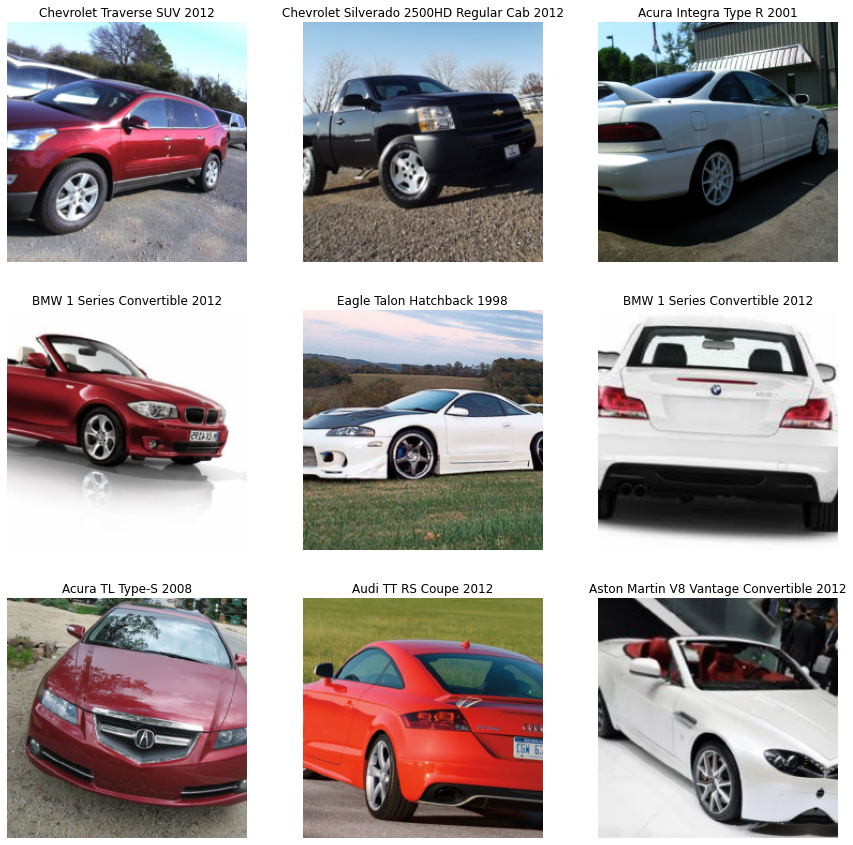

In [10]:
# Write your code here
dls.show_batch(figsize=(15,15))

How many vehicle classes are in the dataset?

__Hint__: use `dls.vocab`

In [11]:
# Write your code here
len(dls.vocab) 

127

## Train the Model

Once the data is ready you can start training a model. Use the `cnn_learner` to create a model with 
- a Resnet34 architecture
- the metrics *accuracy* and [*top-5 accuracy*](https://docs.fast.ai/metrics.html#top_k_accuracy)

In [12]:
# Write your code here
learn = vision_learner(dls, models.resnet34, metrics=[accuracy, top_k_accuracy])

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

Finally, you can train the model. Apply the concepts from the lecture, i.e., 
- finding the learning rate
- training the last layers
- unfreezing the model
- train all layers (learning rate rule of thumb!)

Always provide an explanation **why** you chose the number of epochs and the learning rate.

Save the model after each training 
```
learn.save('stage-x')
``` 
so that you can reload the model 
``` 
learn = learn.load('stage-x')
``` 
if something goes wrong. If you load a model with *freezed* layers, you need to *unfreeze* the layers again.

SuggestedLRs(valley=0.0012022644514217973)

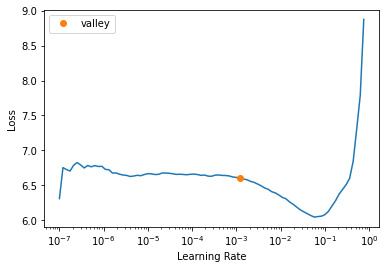

In [13]:
# Write your code and explanations here
learn.lr_find()

In [14]:
# Write your code and explanations here
# Fit the model with the suggested learning rate
learn.fit_one_cycle(20, lr_max=0.002, cbs=[EarlyStoppingCallback(monitor='accuracy', min_delta=0.01, patience=3, comp=np.greater),
                                           SaveModelCallback(monitor='accuracy', min_delta=0.01, comp=np.greater, fname='best_frozen_model')])

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,6.455595,4.994855,0.030265,0.094578,01:08
1,5.595463,3.872797,0.134931,0.335435,01:08
2,4.392448,2.849957,0.293821,0.602774,01:08
3,3.419051,2.290490,0.403531,0.707440,01:08
4,2.654356,1.929003,0.482976,0.781841,01:07
5,2.170947,1.700864,0.522068,0.841110,01:10
6,1.843871,1.565691,0.551072,0.857503,01:07
7,1.571553,1.448176,0.582598,0.875158,01:07
8,1.399578,1.400989,0.607818,0.885246,01:08
9,1.282220,1.329605,0.625473,0.889029,01:07


Better model found at epoch 0 with accuracy value: 0.03026481717824936.
Better model found at epoch 1 with accuracy value: 0.13493064045906067.
Better model found at epoch 2 with accuracy value: 0.29382094740867615.
Better model found at epoch 3 with accuracy value: 0.40353089570999146.
Better model found at epoch 4 with accuracy value: 0.4829760491847992.
Better model found at epoch 5 with accuracy value: 0.5220680832862854.
Better model found at epoch 6 with accuracy value: 0.5510718822479248.
Better model found at epoch 7 with accuracy value: 0.5825977325439453.
Better model found at epoch 8 with accuracy value: 0.6078184247016907.
Better model found at epoch 9 with accuracy value: 0.625472903251648.
Better model found at epoch 11 with accuracy value: 0.6544766426086426.
Better model found at epoch 12 with accuracy value: 0.6784363389015198.
No improvement since epoch 12: early stopping


In [16]:
# Load the best model and validate it
learn = learn.load('best_frozen_model')
learn.validate()

/usr/local/lib/python3.8/dist-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#3) [1.187462568283081,0.6784363389015198,0.9104666113853455]

In [17]:
# Write your code and explanations here
# Since our model is working as we expect it to, we will unfreeze our 
# model and train some more.
learn.unfreeze()

SuggestedLRs(valley=8.31763736641733e-06)

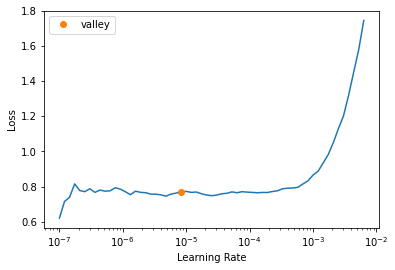

In [18]:
learn.lr_find()

In [19]:
# Write your code and explanations here
# The basic rule of thumb is after you unfreeze (i.e. train the whole thing),
# pass a max learning rate parameter, pass it a slice, make the second 
# part of that slice about 10 times smaller than your first stage.
learn.fit_one_cycle(
    20, lr_max=slice(1e-5,1e-4), 
    cbs=[EarlyStoppingCallback(monitor='accuracy', min_delta=0.01, patience=3, comp=np.greater),
         SaveModelCallback(monitor='accuracy', comp=np.greater, fname='best_model')]
         )

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.757925,1.168814,0.677175,0.910467,01:19
1,0.741941,1.128928,0.687264,0.912989,01:10
2,0.686631,1.101690,0.678436,0.916772,01:10
3,0.637903,1.068766,0.697352,0.925599,01:11
4,0.585978,1.044740,0.706179,0.933165,01:10
5,0.541130,1.010856,0.716267,0.936948,01:10
6,0.489468,0.997885,0.713745,0.936948,01:11
7,0.452022,0.944403,0.738966,0.939470,01:09
8,0.389101,0.946852,0.717528,0.943253,01:11
9,0.367656,0.922256,0.718789,0.940731,01:10


Better model found at epoch 0 with accuracy value: 0.6771752834320068.
Better model found at epoch 1 with accuracy value: 0.687263548374176.
Better model found at epoch 3 with accuracy value: 0.6973518133163452.
Better model found at epoch 4 with accuracy value: 0.7061790823936462.
Better model found at epoch 5 with accuracy value: 0.7162673473358154.
Better model found at epoch 7 with accuracy value: 0.7389659285545349.
No improvement since epoch 7: early stopping


In [20]:
# Load the best model and validate it
learn = learn.load('best_model')
learn.validate()

/usr/local/lib/python3.8/dist-packages/fastai/learner.py:58: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


(#3) [0.9444025158882141,0.7389659285545349,0.9394703507423401]

## Result Interpretation






Explain the difference betweeen the metrics *accuracy* and *top_5_accuracy*. Why can it be useful to report both metrics?

In [21]:
# Write your answer here
# Top-1 accuracy is the conventional accuracy: the model answer 
# (the one with highest probability) must be exactly the expected answer.
# Top-5 accuracy means that any of your model 5 highest probability answers 
# must match the expected answer.
# Depending on the problem, both metrics can provide useful insights about 
# the model's performance

Use the [ClassificationInterpretation](https://docs.fast.ai/interpret.html) to analyze the results in more detail. What are your main findings?

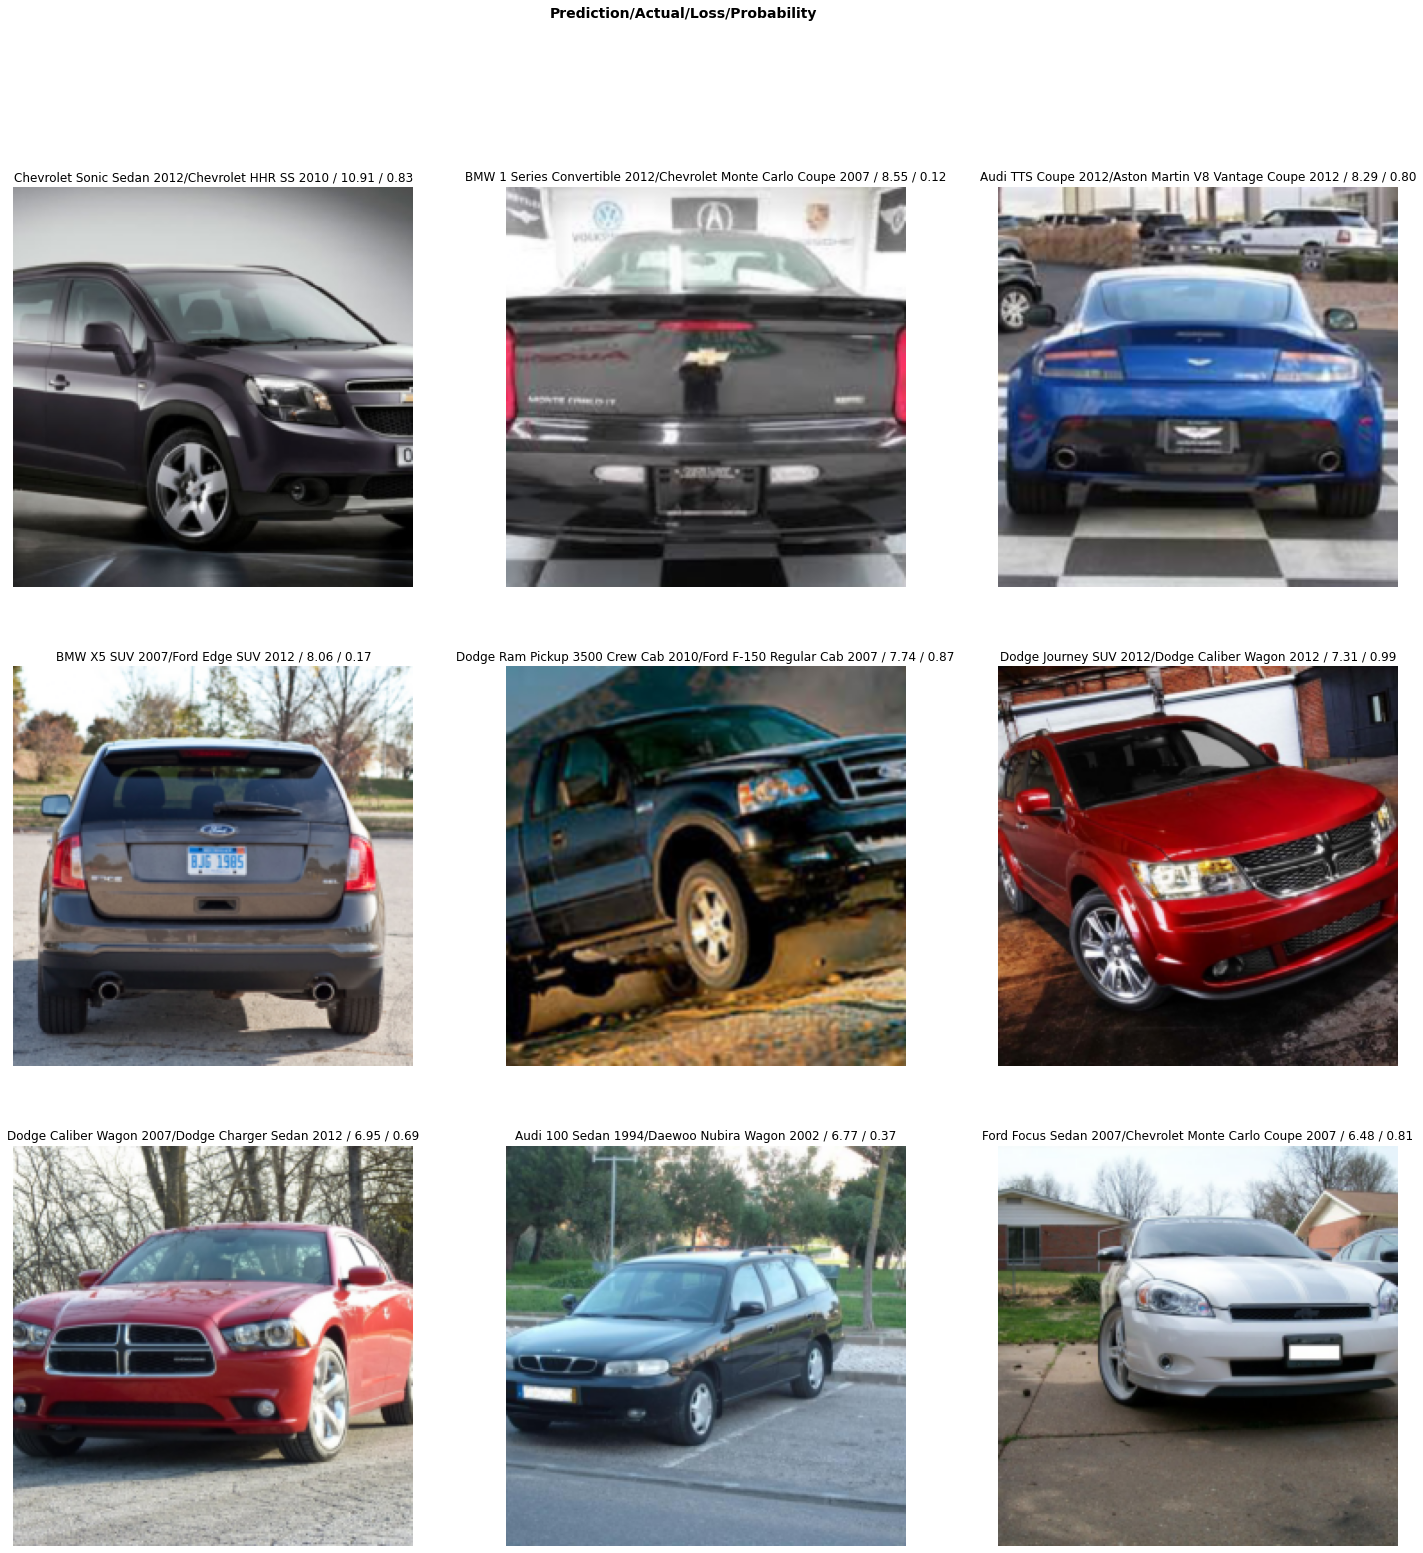

In [22]:
# Write your code and explanations here
# E.g., try explaing the top losses
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(25,25))